# Install Data & Packages

In [2]:
!pip install statsmodels --quiet

In [3]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from sklearn.preprocessing import StandardScaler
import os
import statsmodels as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from numpy.linalg import inv, eig
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

Import Data.

In [4]:
path_data = '/content/data.csv' #edit path as necessary

# Check if files exist before loading
if os.path.exists(path_data):
    data = pd.read_csv(path_data)
    print("Data loaded successfully.")
else:
    print("Error: One or both files not found. Check the file paths.")

y = data.loc[:,'ViolentCrimesPerPop']
X = data.loc[:, data.columns != 'ViolentCrimesPerPop']

Data loaded successfully.


Import Significant Features Data from notebook 1. (So we do not have to run best subsets and SFS again).

In [5]:
file_path = "/content/SignificantFeaturesData.json" #adjust as needed

if os.path.exists(file_path):
    with open(file_path, "r") as f:
        significantfeatures_dict = json.load(f)
    print("JSON file loaded successfully.")
else:
    # Default data if file isn't found
    significantfeatures_dict = {"default_key": ["default_value1", "default_value2"]}
    print("File not found. Loaded default data.")

JSON file loaded successfully.


# Split and Store Data

We want to split the data into 60% training, 20% validation, and 20% test set.
 We will then use the data as follows:

Training $\rightarrow$ fit the model

Validation $\rightarrow$ hyperparameter tuning (if needed, e.g. LASSO)

Test set $\rightarrow$ evaluate MSE using model we fit with the training data

In [6]:
data_splits = {}

M = 10 #number of iterations
for i in range(M):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(100))
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=np.random.randint(100))

    data_splits[f"data{i+1}"] = {
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test
    }

It is not necessarily a fair comparison of MSE between methods that have a validation set and those that dont as the methods that have a validation set use more of the data.  However, for the simplicity of the analysis, assume that this difference is negligible, i.e., 'wasting' the validation data for methods that do not require hyper parameter tuning is not impactful on the outcome of the analysis.

Store all MSE below.

In [7]:
methods_mse = {'Least Squares':[],
               'Best Subsets':[],
               'SFS':[],
               'LASSO':[],
               'Ridge':[],
               'Elastic Net':[]
}

# Train, Validation, Test

Now we calculate MSE for each method on datasets 1,2,...,10.

## Least Squares

In [8]:
alldata = list(data_splits.keys())
ls_mse = {data_i:0 for data_i in alldata}

for data_i in alldata:

  X = data_splits[data_i]['X_train']
  X = sm.add_constant(X) #add constant

  y = data_splits[data_i]['y_train']

  lsmodel = OLS(y,X).fit()
  y_pred = lsmodel.predict(X)
  mse = mean_squared_error(y, y_pred)
  ls_mse[data_i] = mse

In [9]:
ls_mse

{'data1': 0.015602336260244066,
 'data2': 0.0158641606355822,
 'data3': 0.017188819382675656,
 'data4': 0.014729640049464816,
 'data5': 0.015489741462072168,
 'data6': 0.014339495235820215,
 'data7': 0.01583017758992238,
 'data8': 0.01639229693048463,
 'data9': 0.01546021104819502,
 'data10': 0.015200728061348598}

Add this to the dictionary storing the MSE for all methods.

In [10]:
methods_mse['Least Squares'] = ls_mse

## Best Subsets

We have already run this in notebook 1.  Import these variables and fit a LS model to the subset of variables that were deemed significant.

In [11]:
significantfeaturesBestSubsets = significantfeatures_dict['Best Subsets']
print(significantfeaturesBestSubsets)

['PctVacantBoarded', 'PctWOFullPlumb', 'LemasPctOfficDrugUn', 'NumStreet', 'MedRentPctHousInc', 'PctHousOccup', 'PopDens', 'blackPerCap']


In [12]:
BestSubests_mse = {data_i:0 for data_i in alldata}

for data_i in alldata:

  X = data_splits[data_i]['X_train']
  X = X[significantfeaturesBestSubsets] #Drop all unneccessary features
  X = sm.add_constant(X) #add constant

  y = data_splits[data_i]['y_train']

  SFS_lsmodel = OLS(y,X).fit()
  y_pred = SFS_lsmodel.predict(X)
  mse = mean_squared_error(y, y_pred)
  BestSubests_mse[data_i] = mse

methods_mse['Best Subsets'] = BestSubests_mse

## Sequential Feature Selection (SFS)

We have already run this in notebook 1.  Import significant coefficients.

In [13]:
significantfeaturesSFS = significantfeatures_dict['SFS']
print(significantfeaturesSFS)

['racepctblack', 'racePctWhite', 'racePctHisp', 'agePct12t29', 'agePct16t24', 'numbUrban', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWRetire', 'medFamInc', 'whitePerCap', 'indianPerCap', 'AsianPerCap', 'HispPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctBSorMore', 'PctEmploy', 'PctEmplManu', 'PctOccupManu', 'MalePctDivorce', 'MalePctNevMarr', 'TotalPctDiv', 'PctKids2Par', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'PctVacMore6Mos', 'RentLowQ', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctUsePubTrans', 'LemasPctOfficDrugUn', 'OtherPerCap']


In [14]:
SFS_mse = {data_i:0 for data_i in alldata}

for data_i in alldata:

  X = data_splits[data_i]['X_train']
  X = X[significantfeaturesSFS] #Drop all unneccessary features
  X = sm.add_constant(X) #add constant

  y = data_splits[data_i]['y_train']

  SFS_lsmodel = OLS(y,X).fit()
  y_pred = SFS_lsmodel.predict(X)
  mse = mean_squared_error(y, y_pred)
  SFS_mse[data_i] = mse

methods_mse['SFS'] = SFS_mse

## LASSO

In [15]:
lasso_mse2 = {data_i: {} for data_i in alldata}

for data_i in alldata:
    X_train, y_train = data_splits[data_i]['X_train'], data_splits[data_i]['y_train']
    X_val, y_val = data_splits[data_i]['X_val'], data_splits[data_i]['y_val']
    X_test, y_test = data_splits[data_i]['X_test'], data_splits[data_i]['y_test']

    # Center and scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    lasso_model = Lasso(max_iter=1000000)

    # Hyperparameter tuning by manually testing alpha values on the validation set
    alpha_values = np.logspace(-4, 4, 10)
    best_alpha = None
    best_mse = float('inf')  # Initialize with a large value to track minimum MSE

    for alpha in alpha_values:
        lasso_model.set_params(alpha=alpha)
        lasso_model.fit(X_train_scaled, y_train)
        y_val_pred = lasso_model.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_val_pred)

        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha

    lasso_best = Lasso(alpha=best_alpha, max_iter = 1000000)
    lasso_best.fit(X_train_scaled, y_train)
    y_test_pred = lasso_best.predict(X_test_scaled)

    mse_test = mean_squared_error(y_test, y_test_pred)
    lasso_mse2[data_i] = mse_test

#Add data
methods_mse['LASSO'] = {'Parameter': best_alpha, 'MSE':lasso_mse2}

## Ridge

In [16]:
ridge_mse = {data_i: {} for data_i in alldata}

for data_i in alldata:
    X_train, y_train = data_splits[data_i]['X_train'], data_splits[data_i]['y_train']
    X_val, y_val = data_splits[data_i]['X_val'], data_splits[data_i]['y_val']
    X_test, y_test = data_splits[data_i]['X_test'], data_splits[data_i]['y_test']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    ridge_model = Ridge(max_iter=10000)

    alpha_values = np.logspace(-4, 4, 10)
    best_alpha = None
    best_mse = float('inf')

    for alpha in alpha_values:
        ridge_model.set_params(alpha=alpha)
        ridge_model.fit(X_train_scaled, y_train)
        y_val_pred = ridge_model.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_val_pred)

        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha

    ridge_best = Ridge(alpha=best_alpha)
    ridge_best.fit(X_train_scaled, y_train)

    y_test_pred = ridge_best.predict(X_test_scaled)

    mse_test = mean_squared_error(y_test, y_test_pred)
    ridge_mse[data_i] = mse_test

#Add data
methods_mse['Ridge'] = {'Parameter': best_alpha, 'MSE':ridge_mse}

## Elastic Net

In [43]:
import warnings
import time

start = time.time()

warnings.filterwarnings("ignore")

elasticnet_mse = {data_i: {} for data_i in alldata}

for data_i in alldata:
    X_train, y_train = data_splits[data_i]['X_train'], data_splits[data_i]['y_train']
    X_val, y_val = data_splits[data_i]['X_val'], data_splits[data_i]['y_val']
    X_test, y_test = data_splits[data_i]['X_test'], data_splits[data_i]['y_test']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    elasticnet_model = ElasticNet(max_iter=10000)

    alpha_values = np.logspace(-4, 4, 10)
    l1_ratio_values = np.linspace(0, 1, 10)  # L1 ratio ranges from 0 (Ridge) to 1 (Lasso)
    best_alpha = None
    best_l1_ratio = None
    best_mse = float('inf')

    # We loop through all combinations of penalty (alpha) and ratio between l1 and l2 to find best combination in set  {alpha_values, l1_ratio_values}
    for alpha in alpha_values:
        for l1_ratio in l1_ratio_values:
            elasticnet_model.set_params(alpha=alpha, l1_ratio=l1_ratio)
            elasticnet_model.fit(X_train_scaled, y_train)
            y_val_pred = elasticnet_model.predict(X_val_scaled)
            mse = mean_squared_error(y_val, y_val_pred)

            if mse < best_mse:
                best_mse = mse
                best_alpha = alpha
                best_l1_ratio = l1_ratio

    elasticnet_best = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)
    elasticnet_best.fit(X_train_scaled, y_train)

    y_test_pred = elasticnet_best.predict(X_test_scaled)

    mse_test = mean_squared_error(y_test, y_test_pred)
    elasticnet_mse[data_i] = mse_test

end = time.time()
passed = end - start
print(f"Execution time: {passed:.4f} seconds")

# Add data
methods_mse['Elastic Net'] = {'Parameters (alpha, l1 ratio)': (best_alpha, best_l1_ratio), 'MSE': elasticnet_mse}

Execution time: 170.4319 seconds


# Compare Methods (MSE)

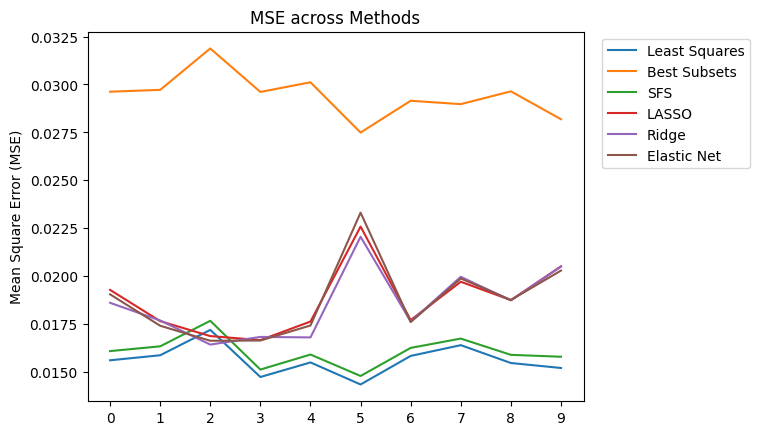

In [84]:
for key, val in methods_mse.items():
  if len(list(methods_mse[key])) == 10:
    plt.plot(methods_mse[key].values(), label = key)
  else:
    plt.plot(methods_mse[key]['MSE'].values(), label = key)

plt.ylabel('Mean Square Error (MSE)')
plt.title('MSE across Methods')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1));
plt.xticks(range(0, 10, 1));

Suprisingly, Best Subsets performed very poorly compared to the other methods.  This is likely due to the fact that in order to perform best subsets within a reasonable computational time we had to perform extensive feature filtering.  Clearly, this led to poor predictive performance in the model.

It appears that in this regression analysis, LS and SFS performed the best according the the MSE.